In [1]:
import calendar
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [8]:
def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    plot_data(df.ix[start_index:end_index,columns])

def symbol_to_path(symbol, base_dir="Daily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def normalize_data(df):
    return df/df.ix[0,:]

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)

        if symbol == 'TASI':  # drop dates SPY did not tradenumpy-1.11.1+mkl-cp27-cp27m-win32.whl
            df = df.dropna(subset=["TASI"])

    return df

def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1
    daily_returns = daily_returns[1:]
    daily_returns.plot(kind="hist")
    plt.show()
    return daily_returns

In [99]:
dates = pd.date_range('01-11-2012', '06-07-2017')
symbols = ['TASI']
df = get_data(symbols, dates,'Close')
df = df.resample('M').mean()
df = df.iloc[::-1]


TASI    6911.625217
Name: 2017-05-31 00:00:00, dtype: float64


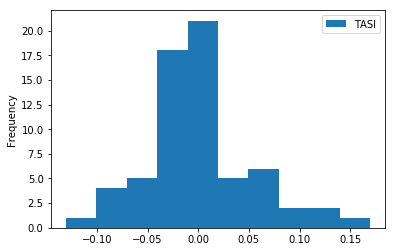

                TASI
2017-05-31  0.997759
2017-04-30  1.012437
2017-03-31  0.987507
2017-02-28  1.020038
2017-01-31  1.000626
2016-12-31  1.011444
2016-11-30  0.914709
2016-10-31  0.869296
2016-09-30  1.051394
2016-08-31  1.042864
2016-07-31  1.054389
2016-06-30  0.995614
2016-05-31  1.012463
2016-04-30  0.979064
2016-03-31  0.977445
2016-02-29  0.930296
2016-01-31  1.016190
2015-12-31  1.169645
2015-11-30  1.009918
2015-10-31  1.064187
2015-09-30  0.997314
2015-08-31  1.096484
2015-07-31  1.118560
2015-06-30  1.028958
2015-05-31  1.029281
2015-04-30  0.947435
2015-03-31  1.011198
2015-02-28  0.996105
2015-01-31  0.909226
2014-12-31  1.004803
...              ...
2014-06-30  0.991217
2014-05-31  1.006425
2014-04-30  0.976380
2014-03-31  0.977676
2014-02-28  0.956900
2014-01-31  0.973934
2013-12-31  0.967580
2013-11-30  0.984814
2013-10-31  0.971403
2013-09-30  0.980908
2013-08-31  1.016529
2013-07-31  0.962741
2013-06-30  0.976411
2013-05-31  0.961855
2013-04-30  0.985150
2013-03-31  0

In [107]:
returns = compute_daily_returns(df)
grossreturns = 1 + returns
lookback = 11
momentum = 1
tempIdx = 0
print grossreturns
count = len(grossreturns) - lookback + 1
dfMom = pd.DataFrame()
i=0
j=0
while i < count:    
    j=i
    print j
    for idx, row in grossreturns.iterrows():
        if lookback > 0 :
            if tempIdx == 0:
                tempIdx = grossreturns.iloc[j].name
                print tempIdx
            momentum = momentum * grossreturns.iloc[j][0]
            lookback-=1
            j+=1
            print j,i
        else:
            momentum = momentum - 1
            momentum = { 'Mom':momentum}       
            dfMom = dfMom.append(pd.DataFrame(data=momentum,index=[tempIdx]))
            momentum = 1
            tempIdx = 0
            lookback=11            
            break
    i+=1
print dfMom